In [2]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

In [3]:
import sys
sys.path.append('../') # go to parent dir
sys.path.append('/home/artem/git/sdafe')

In [11]:
from sdafe.ch12.unitroot import adf_test

In [4]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, numpy2ri, default_converter

np_cv_rules = default_converter + numpy2ri.converter

### 12.15.1 T-bill Rates

In [5]:
data = pd.read_csv('../data/TbGdpPi.csv')
data.index = pd.date_range(start='1955', freq='Q', periods=data.shape[0])
data.head()
# r = the 91-day Treasury bill rate
# y = the log of real GDP
# pi = the inflation rate

,r,y,pi
1955-03-31,1.41,7.894976,0.000000
1955-06-30,1.47,7.911123,0.000000
1955-09-30,2.15,7.924480,0.749064
1955-12-31,2.50,7.930480,-0.371747
1956-03-31,2.30,7.926614,0.000000


In [6]:
def plot_ts(data, cols):
    fig, axs = plt.subplots(len(cols), 1, figsize=(len(cols) * 3 + 1, 8), sharex=True)

    for i, col in enumerate(cols):
        axs[i].plot(data[col]);
        axs[i].set_ylabel(col);

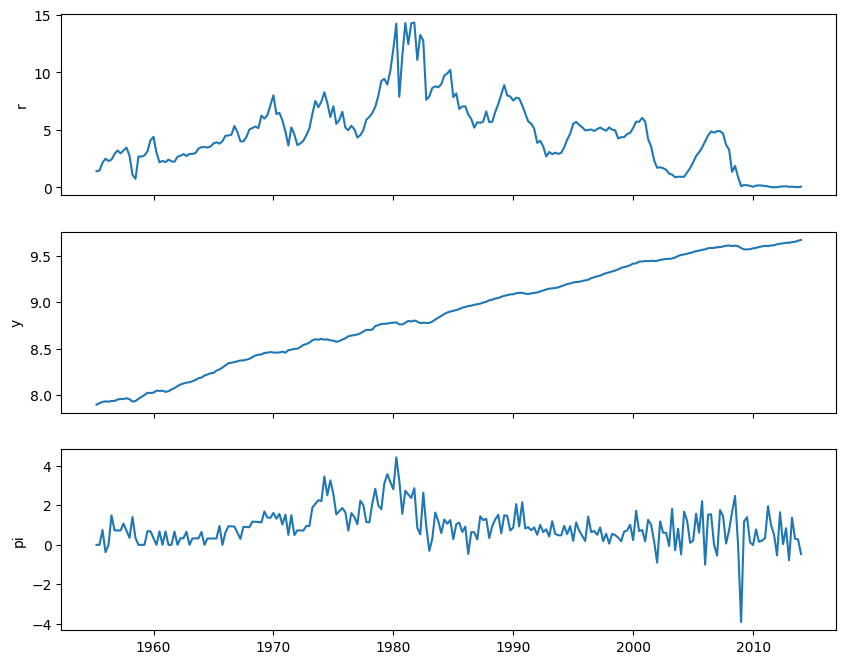

In [7]:
plot_ts(data, ['r', 'y', 'pi'])

In [8]:
import statsmodels.graphics.tsaplots as tsaplots

In [9]:
def plot_acfs(data, cols):
    fig, axs = plt.subplots(len(cols), 1, figsize=(len(cols) * 3 + 1, 8), sharex=True)

    for i, col in enumerate(cols):
        tsaplots.plot_acf(data[col], ax=axs[i]);
        axs[i].set_title(col);

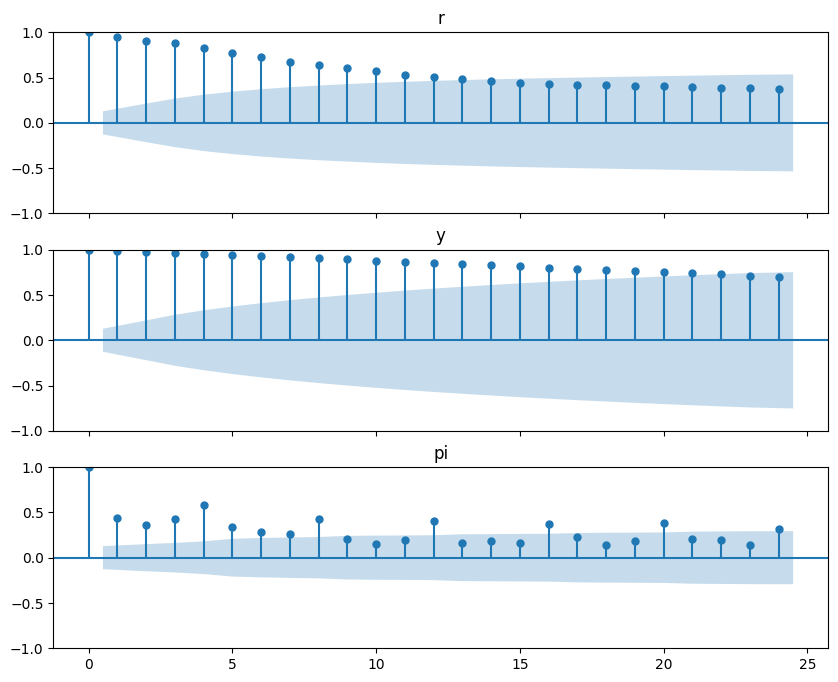

In [10]:
plot_acfs(data, ['r', 'y', 'pi'])

In [12]:
adf_test(data['r'])

(-2.562223628194525,
 0.297581682815403,
 6,
 229,
 {'1%': -3.998856453913814,
  '5%': -3.429838138665128,
  '10%': -3.138417539315758})

In [13]:
adf_test(data['y'])

(-1.3473603965694378,
 0.8757105830585536,
 6,
 229,
 {'1%': -3.998856453913814,
  '5%': -3.429838138665128,
  '10%': -3.138417539315758})

In [14]:
adf_test(data['pi'])

(-3.144354820938792,
 0.09607055714859064,
 6,
 229,
 {'1%': -3.998856453913814,
  '5%': -3.429838138665128,
  '10%': -3.138417539315758})

#### Problem 1

(a) There is no clear reversion to the mean in the plot of $r$. The plot of $y$ is by large an increasing trend. The plot of $pi$ suggest presence of different regimes.

The ACF plots for $r$ and $y$ show autocorrelations that decrease very slowly with the lag. The ACF plot for $pi$ shows somewhat faster decreasing autocorrelations, but also some seasonality as evidenced by the significant autocorrelations at every 4th lag.

(b) The augmented Dickey-Fuller test does not allow us to reject the null hypothesis of a unit root (and hence non-stationarity).

In [15]:
diff_rate = data.diff().dropna()

In [16]:
adf_test(diff_rate['r'])

(-6.342456951976649,
 4.0742646378145134e-07,
 6,
 228,
 {'1%': -3.9990347583703216,
  '5%': -3.4299237913352556,
  '10%': -3.138467743111241})

In [17]:
adf_test(diff_rate['y'])

(-5.66468168909055,
 1.079861020969086e-05,
 6,
 228,
 {'1%': -3.9990347583703216,
  '5%': -3.4299237913352556,
  '10%': -3.138467743111241})

In [18]:
adf_test(diff_rate['pi'])

(-7.952079348607547,
 9.221466205867329e-11,
 6,
 228,
 {'1%': -3.9990347583703216,
  '5%': -3.4299237913352556,
  '10%': -3.138467743111241})

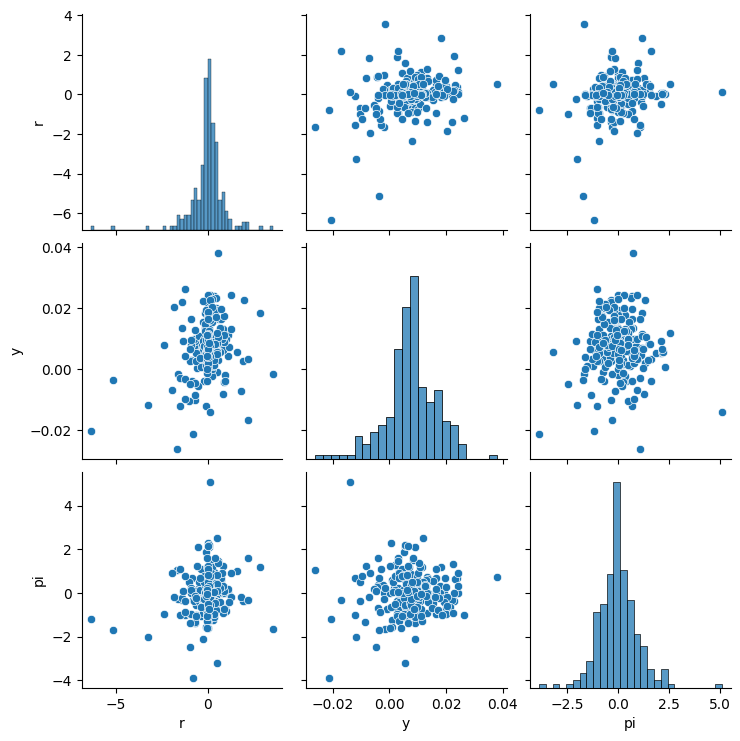

In [19]:
sns.pairplot(diff_rate);

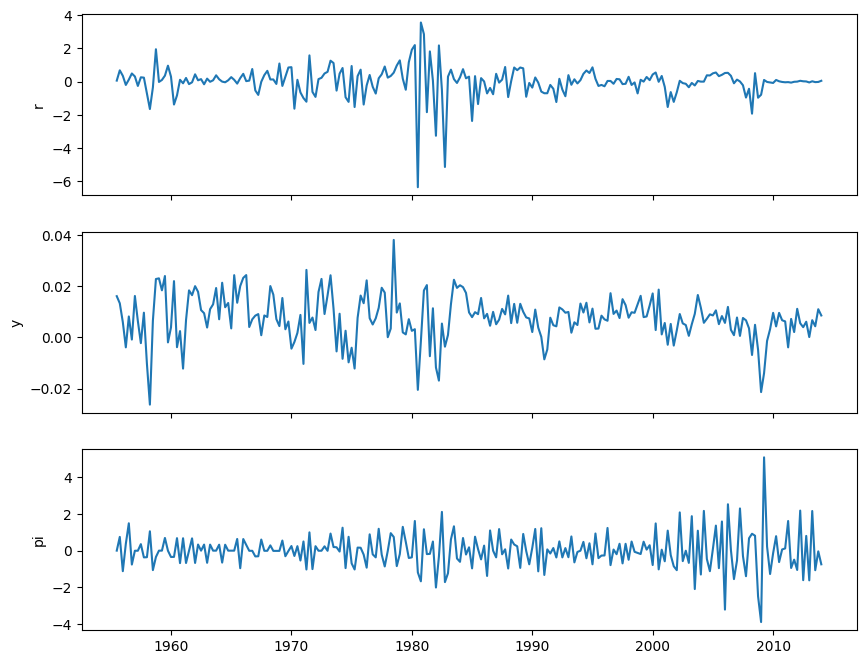

In [20]:
plot_ts(diff_rate, ['r', 'y', 'pi'])

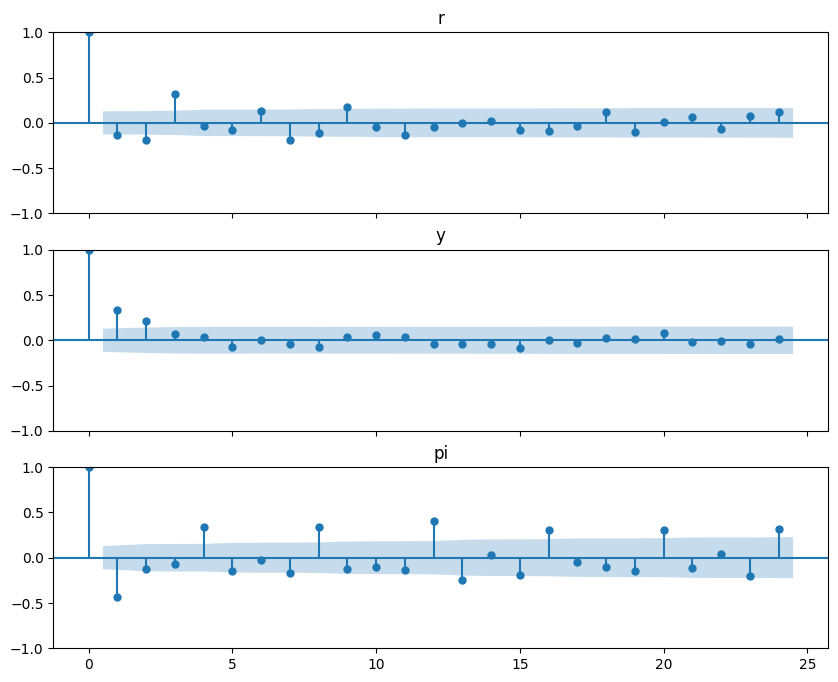

In [21]:
plot_acfs(diff_rate, ['r', 'y', 'pi'])

#### Problem 2

(a) The differenced time series appear stationary according to the augmented Dickey-Fuller test (all p-values are very small).

(b) The appears to be a significant positive correlation in the differenced series for $r$ at lag 3. The autocorrelation plot for differenced series for $y$ shows decay characteristic of an AR model with positive coefficients. The ACF plot of differenced $pi$ shows a quick decay component consistent with an AR model with a negative coeffient and significant seasonality at every 4th lag.

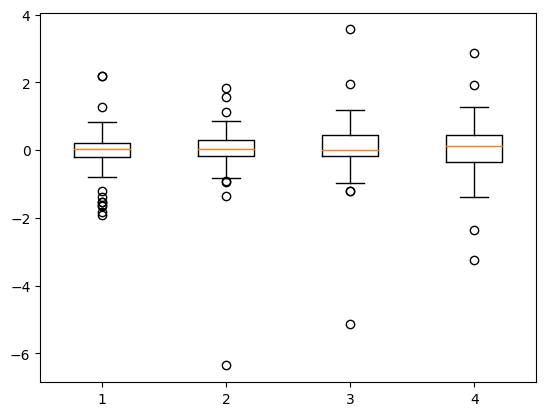

In [22]:
fig, ax = plt.subplots()
ax.boxplot([diff_rate['r'][diff_rate.index.quarter == q] for q in [1, 2, 3, 4]]);

#### Problem 3

The mean appears to be higher in the 4th quarter.

In [23]:
import pmdarima as pm

In [24]:
stepwise_fit = pm.auto_arima(data['r'], seasonal=False)

In [25]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  236
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -299.804
Date:                Fri, 21 Apr 2023   AIC                            607.608
Time:                        18:17:25   BIC                            621.446
Sample:                    03-31-1955   HQIC                           613.187
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1438      0.037     -3.932      0.000      -0.215      -0.072
ma.L2         -0.1008      0.046     -2.173      0.030      -0.192      -0.010
ma.L3          0.3312      0.036      9.138      0.000       0.260       0.402
sigma2         0.7498      0.037     20.065      0.000       0.677       0.823
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1510.92
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -1.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Problem 4

1. The algorithm chooses order 1 differencing.

2. ARIMA(0, 1, 3)

3. AIC

4. The best fitting model remains the same when using BIC:

In [26]:
pm.auto_arima(data['r'], seasonal=False, information_criterion='bic').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  236
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -299.804
Date:                Fri, 21 Apr 2023   AIC                            607.608
Time:                        18:17:30   BIC                            621.446
Sample:                    03-31-1955   HQIC                           613.187
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1438      0.037     -3.932      0.000      -0.215      -0.072
ma.L2         -0.1008      0.046     -2.173      0.030      -0.192      -0.010
ma.L3          0.3312      0.036      9.138      0.000       0.260       0.402
sigma2         0.7498      0.037     20.065      0.000       0.677       0.823
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1510.92
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -1.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

5. The model chosen:

$$\Delta Y_t = \epsilon_t - 0.1438 \epsilon_{t-1} - 0.1008 \epsilon_{t-2} + 0.3312 \epsilon_{t-3},$$
or equivalently
$$Y_t = Y_{t-1} + \epsilon_t - 0.1438 \epsilon_{t-1} - 0.1008 \epsilon_{t-2} + 0.3312 \epsilon_{t-3},$$

In [27]:
mod = sm.tsa.arima.ARIMA(data['r'], order=(0, 1, 3)).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      r   No. Observations:                  236
Model:                 ARIMA(0, 1, 3)   Log Likelihood                -299.804
Date:                Fri, 21 Apr 2023   AIC                            607.608
Time:                        18:17:31   BIC                            621.446
Sample:                    03-31-1955   HQIC                           613.187
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1438      0.037     -3.932      0.000      -0.215      -0.072
ma.L2         -0.1008      0.046     -2.173      0.030      -0.192      -0.010
ma.L3          0.3312      0.036      9.138      0.000       0.260       0.402
sigma2         0.7498      0.037     20.065      0.000       0.677       0.823
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1510.92
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -1.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

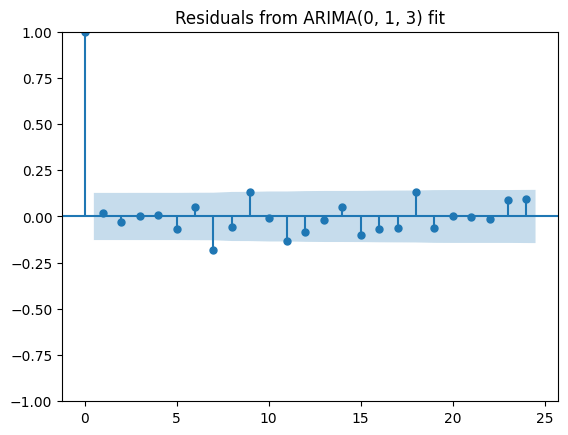

In [28]:
fig, ax = plt.subplots()
tsaplots.plot_acf(stepwise_fit.resid(), ax=ax);
ax.set_title('Residuals from ARIMA(0, 1, 3) fit');

In [29]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [30]:
acorr_ljungbox(stepwise_fit.resid(), lags=[12], model_df=3)

,lb_stat,lb_pvalue
12,21.309352,0.011345


#### Problem 5

The result of the Ljung-Box test suggest there is still autocorrelation in the residuals.

Looking at the plot of residuals, we can see volatility clustering, so a more advanced model than ARIMA might be appropriate.

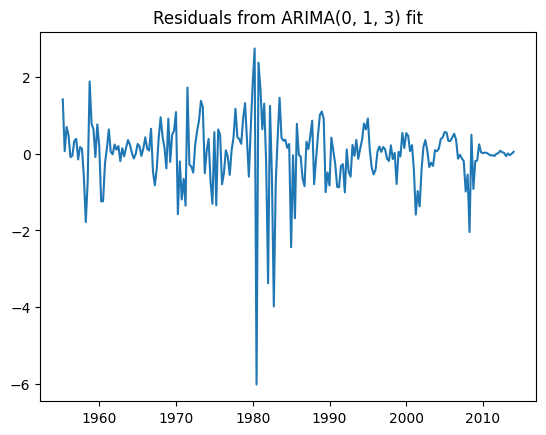

In [31]:
fig, ax = plt.subplots()
ax.plot(stepwise_fit.resid());
ax.set_title('Residuals from ARIMA(0, 1, 3) fit');

In [32]:
resid2 = (stepwise_fit.resid() - stepwise_fit.resid().mean()) ** 2

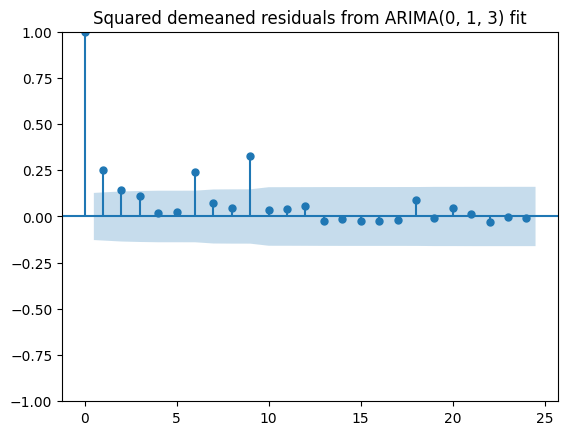

In [33]:
fig, ax = plt.subplots()
tsaplots.plot_acf(resid2, ax=ax);
ax.set_title('Squared demeaned residuals from ARIMA(0, 1, 3) fit');

In [34]:
acorr_ljungbox(resid2, lags=[12], model_df=3)

,lb_stat,lb_pvalue
12,67.607939,4.474974e-11


#### Problem 6

The Ljung-Box test presents strong evidence of volatility clustering in the residuals.

### 12.15.2 Forecasting

In [35]:
pi_fit = pm.auto_arima(data['pi'], seasonal=False, information_criterion='bic')
pi_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  236
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -267.560
Date:                Fri, 21 Apr 2023   AIC                            539.119
Time:                        18:17:40   BIC                            546.038
Sample:                    03-31-1955   HQIC                           541.909
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7882      0.035    -22.838      0.000      -0.856      -0.721
sigma2         0.5684      0.025     22.940      0.000       0.520       0.617
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               539.67
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.76   Skew:                            -1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
forecast = pi_fit.predict(36, return_conf_int=True, alpha=0.05)

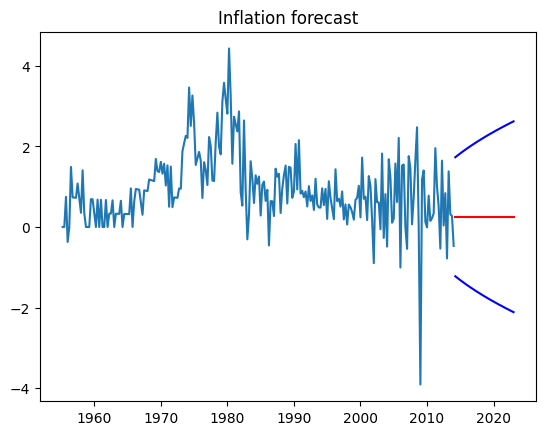

In [37]:
fig, ax = plt.subplots()
ax.plot(data['pi']);
ax.plot(forecast[0], color='red');
ax.plot(forecast[0].index, forecast[1][:, 0], color='blue');
ax.plot(forecast[0].index, forecast[1][:, 1], color='blue');
ax.set_title('Inflation forecast');

#### Problem 7

(a) The forecast interval widens as one moves further into the future, since an integrated model is used.

(b) The selected model is ARIMA(0, 1, 1):
$$\Delta Y_t = \epsilon_t + \theta_1 \epsilon_{t-1},$$
so for $h>2$, 
$$E[\Delta Y_{t+h}|Y_t,Y_{t-1},...,Y_0] = E[\epsilon_{t+h} + \theta_1 \epsilon_{t+h-1}|Y_t,Y_{t-1},...,Y_0] = E[\epsilon_{t+h} + \theta_1 \epsilon_{t+h-1}] = 0$$
and therefore
$$Y_{t+h} = Y_{t+h-1} = \hat{Y}_{t+1} = Y_t + \theta_1 \hat{\epsilon}_t.$$